# Sybil Detection

In [1]:
import os
import pandas as pd
import numpy as np

from avd.graph_learning_controller import GraphLearningController
from avd.learners.sklearner import SkLearner
from avd.configs import config
from avd.datasets.twitter import load_data

Specify output directory for classifiers.

In [2]:
output_folder = os.getcwd() + "/data/output"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Define what is considered positive and negative labels.

In [3]:
labels = {"neg": "Real", "pos": "Fake"}

We first load the Twitter graph.
load_data will return a graph object(twitter_graph) and a config object(twitter_config).

In [4]:
twitter_graph, twitter_config = load_data(dataset_file_name="twitter_filtered.csv", labels_file_name="twitter_labels_filtered.csv", 
                                          labels_map=labels, limit=5000000) # Loads filtered dataset.
print(len(twitter_graph.vertices))

Loading labels...
Loading graph...
Data loaded.
75624


Some of the extracted feature can be useful for understanding the result, but they will not be used in the classification proccess.

In [5]:
if twitter_graph.is_directed:
    meta_data_cols = ["dst", "src", "out_degree_v", "in_degree_v", "out_degree_u", "in_degree_u"]
else:
    meta_data_cols = ["dst", "src", "number_of_friends_u", "number_of_friends_v"]

Finally, we train the classification algorithm.
The Twitter dataset is incomplete and missing a lot of data.
In order to deal with this problem, we train 10 times and aggregate the results.

In [6]:
twitter_config._name = "twitter_" + "linksProbability_"
learner = SkLearner(labels=labels)
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path, 
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000}, 
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.8s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.9s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.6s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.7s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.9s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.7s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.8s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.6s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.8s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.7s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.4s finished


Cross-validation results:
Training 10-fold validation: {'auc': 0.9544674000000001, 'recall': 0.8916000000000001, 'precision': 0.8889551447210284, 'accuracy': 0.8899999999999999, 'fpr': 0.1116, 'tnr': 0.8884000000000001}
Test results:
Validate_prediction_by_links: {'auc': 0.5207275, 'recall': 0.06, 'precision': 0.10714285714285714, 'accuracy': 0.8690909090909091, 'fpr': 0.05}


In [7]:
def aggreagate_res(data_folder, res_path):
    results_frame = pd.DataFrame()
    for f in os.listdir(data_folder):
        temp_df = pd.read_csv(data_folder + "/" + f,index_col=0, encoding='utf-8', engine='python')
        results_frame = results_frame.append(temp_df)
    results_frame = results_frame.groupby("src_id").mean()

    return results_frame.reset_index()

In [8]:
df = aggreagate_res(output_folder, "res.csv").sort_values("mean_link_label", ascending=False)

In order to calculate precision at k, we add two additional columns:
1. The sum of the positive examples.
2. k  the total number of resutls until the specific row. (row number)

In [9]:
df["actual_sum"] = df["actual"].cumsum()
df["k"] = 1
df["k"] = df["k"].cumsum()

In [10]:
df.head(10)

,src_id,neg probability,edge number,pos probability,mean_link_label,sum_link_label,predicted_label,actual,actual_sum,k
1532,618482,0.002114,13,0.997886,1.000000,13,1,0,0,1
2123,2386514,0.009996,13,0.990004,1.000000,13,1,0,0,2
846,215342,0.001007,11,0.998993,1.000000,11,1,1,1,3
7,1984,0.129168,11,0.870832,0.909091,10,1,0,1,4
58,10269,0.085271,11,0.914729,0.909091,10,1,0,1,5
685,158165,0.158197,11,0.841803,0.909091,10,1,0,1,6
1339,440716,0.102128,11,0.897872,0.909091,10,1,0,1,7
1393,489691,0.126421,16,0.873579,0.875000,14,1,0,1,8
2113,2293957,0.179339,14,0.820661,0.857143,12,1,0,1,9
1645,756358,0.132395,21,0.867605,0.857143,18,1,0,1,10


We add an additional column that stores the p@k values by calculating the precision at k.

In [11]:
df["p@k"] = df.apply(lambda x: x["actual_sum"]/x["k"], axis=1)

In [12]:
df[["k", "p@k"]].head(10)

,k,p@k
1532,1,0.000000
2123,2,0.000000
846,3,0.333333
7,4,0.250000
58,5,0.200000
685,6,0.166667
1339,7,0.142857
1393,8,0.125000
2113,9,0.111111
1645,10,0.100000


We can see in the p@k plot that the resuts are musch better then random which about 6%.

<Figure size 432x288 with 0 Axes>

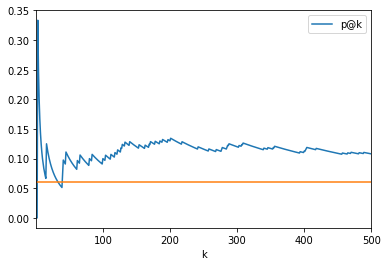

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
df[["k", "p@k"]][:500].plot(x="k", y= "p@k")
plt.plot(df[["k"]].values, np.full((len(df[["k"]]),1), 0.06))

### Logistic Regression

In [14]:
twitter_config._name = "twitter_" + "LogisticRegression_"
IsoForest_learner = SkLearner(labels=labels).set_logistic_regression_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 2000, "pos": 200},
                        training_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.3s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.8s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.0s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.6s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.4s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.3s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   24.6s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   23.5s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   23.2s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   25.1s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.4s finished


Cross-validation results:
Training 10-fold validation: {'auc': 0.9576461999999999, 'recall': 0.8952, 'precision': 0.8963824097080038, 'accuracy': 0.8958, 'fpr': 0.1036, 'tnr': 0.8964000000000001}


### Random Forest

In [15]:
twitter_config._name = "twitter_" + "RandomForest_"
IsoForest_learner = SkLearner(labels=labels).set_randomforest_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 2000, "pos": 200},
                        training_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets


  0%|          | 2/10000 [00:00<08:22, 19.88feature/s]

Extracting features for training set:
Graph loaded


  0%|          | 1/2200 [00:00<03:48,  9.62feature/s]

Features were written to: /Users/anish/Network-Anomaly-Detection/data/temp/twitter_RandomForest__train.csv
Extracting features for test set:
Graph loaded


70320feature [17:04, 68.64feature/s]                     


Features were written to: /Users/anish/Network-Anomaly-Detection/data/temp/twitter_RandomForest__test.csv
Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.3s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.2s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.3s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   20.2s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   20.2s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.9s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.9s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.4s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.9s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.8s finished


Optimizing hyperparameters...
Training classifier...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.7s finished


Cross-validation results:
Training 10-fold validation: {'auc': 0.9574351999999999, 'recall': 0.8916000000000001, 'precision': 0.8920837874223135, 'accuracy': 0.8918000000000001, 'fpr': 0.10800000000000001, 'tnr': 0.892}


### Isolation Forest (deprecated)

In [16]:
# twitter_config._name = "twitter_" + "IsolationForest_" # + str(i) + "_"
# IsoForest_learner = SkLearner(labels=labels).set_isolation_forest_classifier()
# glc = GraphLearningController(IsoForest_learner, twitter_config)
# result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
# glc.evaluate_classifier(twitter_graph, 
#                         test_size={"neg": 2000, "pos": 200},
#                         training_size={"neg": 5000, "pos": 5000}, 
#                         meta_data_cols=meta_data_cols)